In [1]:
%matplotlib inline

## DRAKON models in _itcsimlib_

The DRAKON visual programming language https://en.wikipedia.org/wiki/DRAKON can be used to build complex statistical thermodynamic models with very little actual code. An added benefit is that the visual DRAKON models can be shared and potentially understood more readily than a model constructed in Python or C.

The DRAKON editor/IDE is free and cross-platform, and can be downloaded at http://drakon-editor.sourceforge.net/. There is also a subscription-based web editor available at https://drakonhub.com/.

### Example 1: Non-cooperative binding

To get started with building a DRAKON model, copy the basic itcsimlib DRAKON model of non-cooperative binding to an eight-site circular lattice (noncoop.drn). Note that all itcsimlib DRAKON models must have the following methods (functions):
1. `setup()` defines the size of the Ising latice and any model parameters. This is always a required method.
2. `configuration()` _**OR**_ `site()`. The former is evaluated once for each configuration and determines the configuration's free energy and enthalpy. The latter is evaluated for every site in every potential configuration of the lattice, and thus defines the free energy and enthalpy of each configuration.

_Note: if your model has both a `configuration()` and a `site()` method, the configuration method will take precedence and your `site()` method will be ignored._

![drakon_noncoopsetup](img/drakon_noncoopsetup.png)

The setup method must, at the very least, initialize the model with the specified number of sites in the lattice configurations and whether or not the lattice is circular using `self.initialize()`. This is only relevant when evaluating the occupancy of neighboring sites using the built-in `self.occupied()` method, more on this later.

The setup method should also define all of the model parameters. In the above example, our non-cooperative model has just three:
1. The free energy change upon binding (dG_bind)
2. The enthalpy change upon binding (dH_bind)
3. The heat capacity change upon binding (dCp_bind)

Note that accounting for changes in heat capacity are only necessary if you are performing experiments at multiple temperatures. Note also that you must specify a _type_ for each parameter. Your choices are:
* "dG" for free energy parameters
* "dH" for enthalpy parameters
* "dCp" for heat capacity parameters
* "dS" for entropy parameters
* "n" for stochiometry or other parameters

Unlike `setup()`, which is only called once, and only then to define the model, the `site()` method is called for every site in every lattice configuration to determine the energetics for that particular configuration:

![drakon_noncoopsite](img/drakon_noncoopsite.png)

There are really only three critical functions necessary in the DRAKON flow diagram, all of which are shown above:
1. `self.occupied()`, which tests whether or not the specified site in the current configuration contains a ligand.
2. `self.add_dG()`, which adds the specified free energy to the configuration.
3. `self.add_dH()`, which adds the specified enthalpy to the configuration.

To enable linear van't Hoff-based correction of free energy at different temperatures, you must specify both the reference dG, dH, and dCp values for the `add_dG()` method. If all of your titrations are at the same temperature, or you have a priori knowledge that the heat capacity change is minimal, you can simply leave out the dH and dCp terms. Same goes for the `add_dH()` method.

You may also pass expressions consisting of model parameters as arguments to the `add_dG` and `add_dH` methods. For example, if you wish to explicitly state that some bound states only induce half of a the `dG_bind` parameter in free energy, you could state `self.add_dG(config, '0.5*dG_bind')`. Because each expression must be evaluated individually, this will likely cause the model to take longer to evaluate.

When your model is complete, compile the python module from your diagram by selecting "Generate Code" from the DRAKON menu. If there are no issues with your diagram, you'll have model that is ready to be evaluated in any itcsimlib script:

In [2]:
import noncoop # this is our DRAKON model module

drakon_model = noncoop.Model() 
drakon_model.set_units('kcal')
drakon_model.set_params(dG_bind=-10.0, dH_bind=-5.0, dCp_bind=0.0)

print drakon_model


Model: noncoop.Model

Description:
None

Components:
Index	Name	Description
1)	Lattice	A circular lattice with 8 binding sites
2)	Ligand	A lattice-binding ligand

Parameters:
Index	Param     Type                Value               Description
1)	dG_bind   Free energy         -10.000 kcal/mol    
2)	dH_bind   Enthalpy            -5.000 kcal/mol     
3)	dCp_bind  Heat capacity       0.000 kcal/mol/K    



As you can see, the three model parameters we defined in our DRAKON `setup()` diagram appear correctly. Since this is a non-cooperative model, let's make sure that it provides the same results as a simple non-Ising model:

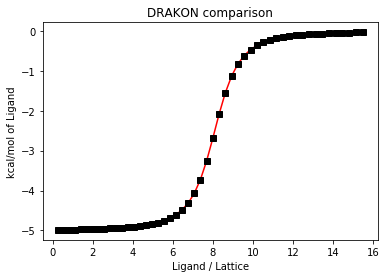

In [3]:
from itcsimlib import *

sim = ITCSim(T0=298.15,units="kcal",verbose=True)
sim.add_experiment_synthetic(
	T=298.15,
	V0=1416.6,
	injections=[5.0]*50,
	Cell={"Lattice":1E-6},
	Syringe={"Ligand":80E-6},
	noise=0.01,
	title='DRAKON comparison')

sim.set_model( drakon_model )
sim.run()
sim.make_plots()

Let's switch the simulator to use a basic single binding model, and re-evaluate.

/Users/elihuihms/miniconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py:208: UserWarning: Convergence precision is greater than 1% of mode 1 Kd (4.7E-08). Setting precision to 1E-10.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


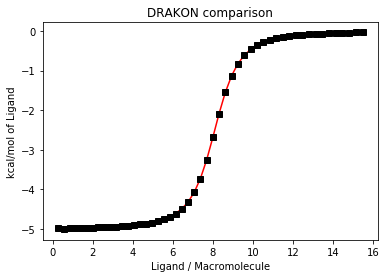

In [4]:
from itcsimlib.model_independent import NModes

# for Ising models, proteins are lattices!
sim.experiments[0].change_component_name(old_name="Lattice",new_name="Macromolecule")

simple_model = NModes(modes=1)
simple_model.set_units('kcal')
simple_model.set_params(n1=8, dG1=-10.0, dH1=-5.0, dCp1=0.0)

sim.set_model( simple_model )
sim.run()
sim.make_plots()

It's apparent that both models provide the same results.

### Example 2: Complex models

Lets generate and evaluate a more complex DRAKON model. In the chaperone GroEL, there are two associated rings of seven sites each. If we define a lattice of 14 sites split into two sets of seven each, we can use the existing Ising model formalism. Here's the `setup()` method for this model:

![drakon_groelsetup](img/drakon_groelsetup.png)

In the previous model, we used `site()` to examine each site of the configuration explicitly and build the aggregate energies for each configuration. In this model, we'll generate the free energies and enthalpies of the configuration directly using `configuration()`:

![drakon_groelconfig](img/drakon_groelconfig.png)

In this model, we add up the free energy and enthalpies of binding as before, but we also keep track of the number of ligands bound to each "ring". If those are larger than some saturation stoichiometry, we can impose an additional free energy (whether it is positive or negative will determine if it is negatively or positively cooperative binding).

Let's first simulate weakly anticooperative binding that kicks in at four ligands per ring:

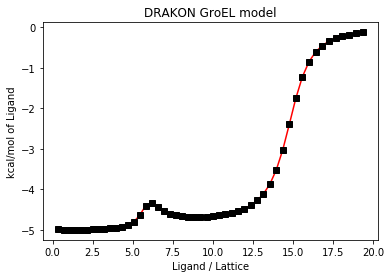

In [6]:
import groel

groel_model = groel.Model()
groel_model.precision = 1E-12
groel_model.set_units('kcal')
groel_model.set_params( dG_bind=-10.0, dG_couple=0.5, ring_sat=4, dH_bind=-5.0)

sim.remove_all_experiments()
sim.add_experiment_synthetic(
	T=298.15,
	V0=1416.6,
	injections=[5.0]*50,
	Cell={"Lattice":1E-6},
	Syringe={"Ligand":1E-4},
	noise=0.01,
	title='DRAKON GroEL model')

sim.set_model( groel_model )
sim.run()
sim.make_plots()

Interesting! How about positive cooperativity?

(Recall that for synthetic models, the dots are always the first set of simulated data for the experiment, and subsequent simulations appear as the solid fit line).

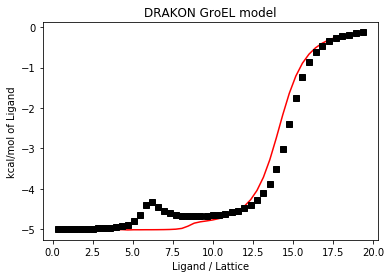

In [10]:
groel_model.set_params( dG_bind=-10.0, dG_couple=-0.5, ring_sat=4, dH_bind=-5.0)

sim.run()
sim.make_plots()

Because this model is just a regular Ising model, we can still easily calculate the partition function:

In [9]:
import sympy
latex_eqn = sympy.latex(groel_model.get_partition_function())

from IPython.display import display, Math
display(Math(latex_eqn))

<IPython.core.display.Math object>